# 문장에 어울리는 이모지를 붙여줘!

어떤 문장이 주어졌을 때, 해당 문장과 어울리는 이모지를 찾는 모델을 LSTM을 통해 구현하고자 한다.

사용할 데이터셋 중 'glove.6B.50d.txt'은 Pre-trained Dataset으로 다른 알고리즘으로 학습된 데이터셋이다. 이를 통해 Train/Test dataset에 없는 새로운 문장이 들어와도 이모지를 붙여줄 수 있는 모델을 만들고자 한다.

In [ ]:
!pip install emoji

In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import emoji
import re

## Utility Function

In [ ]:
#Pre-trained dataset인 glove 불러오기
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def read_csv(filename = 'data/emojify_data.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

#one-hot code로 바꾸기
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/MyDrive/비타민/Emoji data/glove.6B.50d.txt')

**사용할 5가지 이모지들입니다!**

In [ ]:
num_to_emoji={
    0:"❤️",
    1:"⚾️ ",
    2:'😄',
    3:"😩",
    4:"🍔"
}

## 데이터셋 불러오기

**문제 1**

In [ ]:
X_train, Y_train = read_csv('./Emoji data/train_emoji.csv')
X_test, Y_test = read_csv('./Emoji data/test_emoji.csv')
X_test = np.array([re.sub('\t',"",i) for i in X_test])

Y_train_lst, Y_test_lst = list(np.squeeze(Y_train)), list(np.squeeze(Y_test))
X_train_lst, X_test_lst = list(X_train), list(X_test)

X_train, Y_train = X_train.reshape(-1,1), Y_train.reshape(1,-1)
X_test, Y_test = X_test.reshape(-1,1), Y_test.reshape(-1,1)

X_total = list(np.squeeze(np.vstack((X_train,X_test))))

padding을 하기 위해 최대 길이를 알아낸다

In [ ]:
max_len=max(len(l) for l in sequence_train)

In [ ]:
index = 1
print(X_train_lst[index], num_to_emoji[Y_train_lst[index]])

I am proud of your achievements 😄


## 전처리

In [ ]:
import tensorflow as tf
import numpy as np
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical
np.random.seed(1)

Text를 토큰화하기 위한 전처리 단계

In [ ]:
t = Tokenizer()
t.fit_on_texts(X_total)
vocab_size = len(t.word_index) + 1

In [ ]:
#Training dataset
sequence_train = list()
for line in X_train_lst: 
    encoded = t.texts_to_sequences([line])[0]
    sequence_train.append(encoded)

max_len=max(len(l) for l in sequence_train) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
X_train_seq = pad_sequences(sequence_train, maxlen=max_len, padding='post')

In [ ]:
#Test dataset 
sequence_test = list()
for line in X_test_lst: 
    encoded = t.texts_to_sequences([line])[0]
    sequence_test .append(encoded)

X_test_seq = pad_sequences(sequence_test , maxlen=max_len, padding='post')

Target data One-hot coding

In [ ]:
Y_train_oh = convert_to_one_hot(Y_train, C = 5)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)

## Embedding 

앞서 토큰화 시킨 데이터셋을 벡터공간으로 임베딩시켜주는 코드

In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1                 
    emb_dim = word_to_vec_map["cucumber"].shape[0]      
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)

    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [ ]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


## Modeling


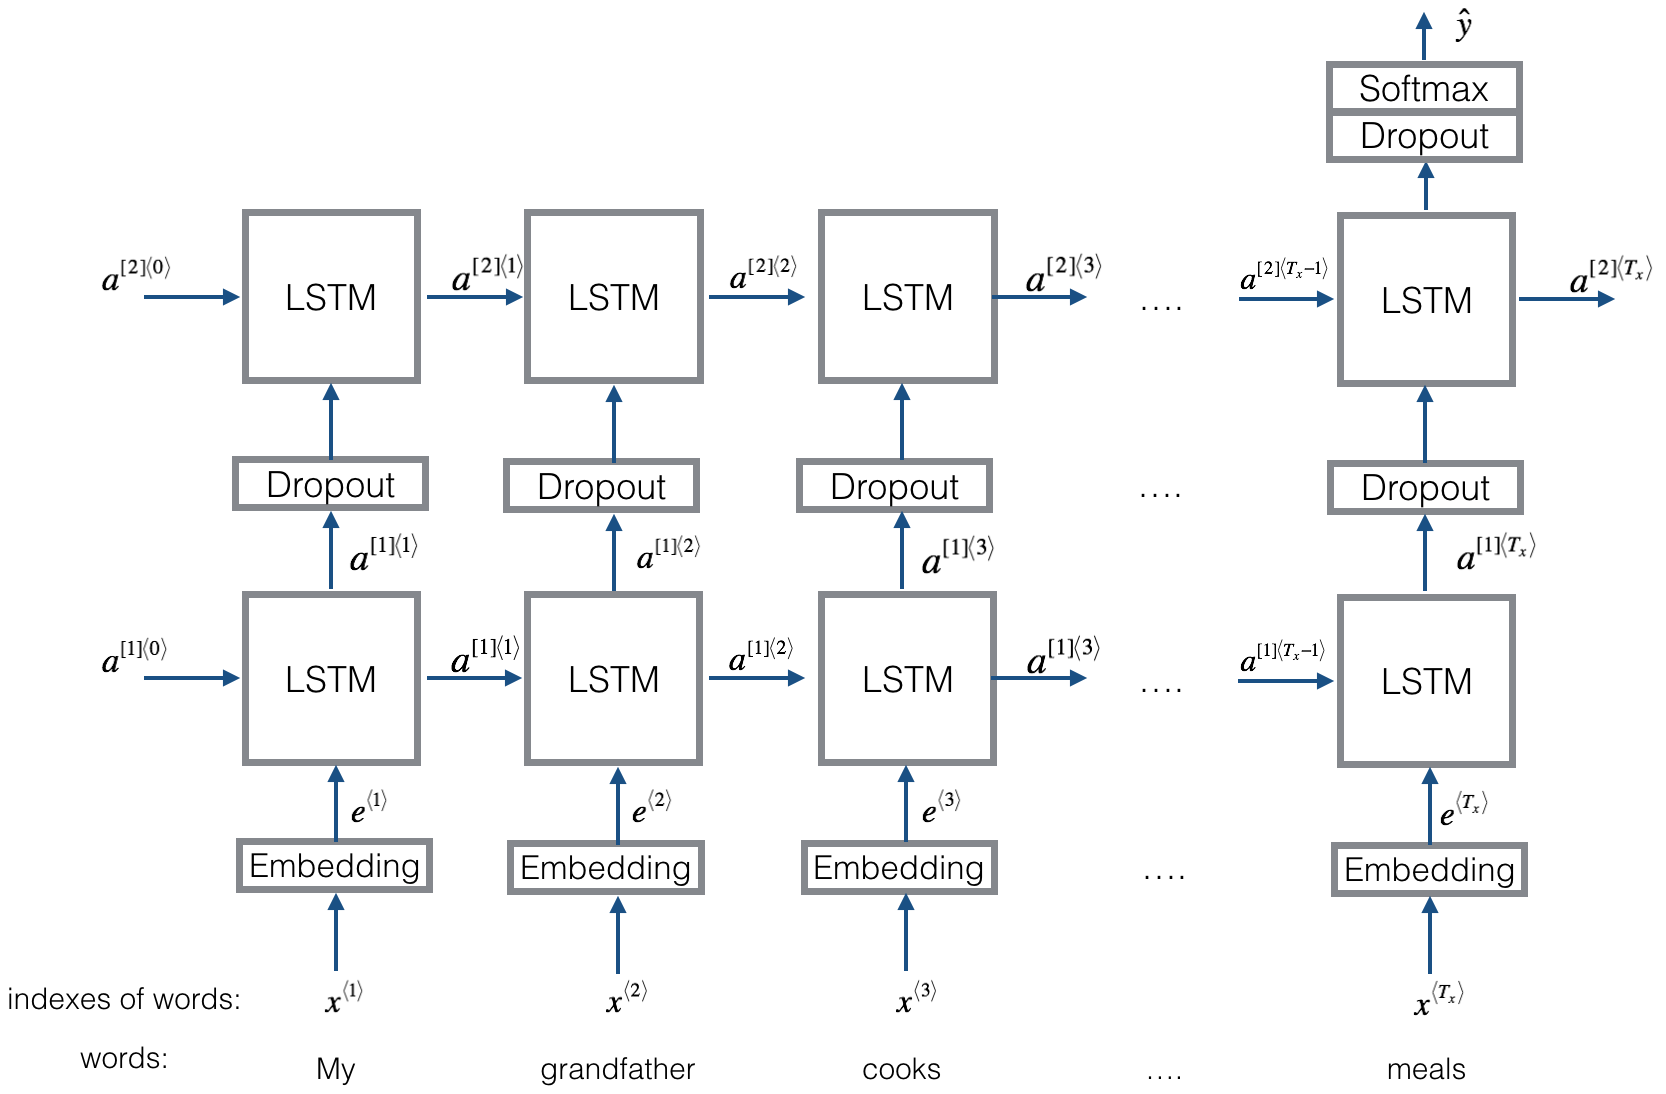

In [ ]:
def Emojify_LSTM(input_shape, word_to_vec_map, word_to_index):
    
    sentence_indices = Input(input_shape, dtype='int32')  
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    
    X = LSTM(128, return_sequences=True)(embeddings)

    X = Dropout(0.5)(X)
    X = LSTM(128, return_sequences=False)(X)    

    X = Dropout(0.5)(X)
    X = Dense(5)(X)

    X = Activation('softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

Model에 대한 설명

In [ ]:
model = Emojify_LSTM((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645   

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train_seq, Y_train_oh, epochs = 50, batch_size = 1, shuffle=True)

Test loss을 산출해봅니다.

In [ ]:
loss, acc = model.evaluate(X_test_seq, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 1s 10ms/step - loss: 3.9948 - accuracy: 0.5357

Test accuracy =  0.5357142686843872


어떤 데이터에 대해서 학습이 잘 진행되지 않았는지 확인하는 코드

In [ ]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
pred = model.predict(X_test_seq)
for i in range(len(X_test)):
    x = X_test_seq
    num = np.argmax(pred[i])
    if num != Y_test[i][0]:
        print('Expected emoji:', num_to_emoji[Y_test[i][0]], ' prediction: ', X_test[i][0], num_to_emoji[num])

Expected emoji: 😩  prediction:  he did not answer ⚾️ 
Expected emoji: 😄  prediction:  she got me a nice present ❤️
Expected emoji: 😄  prediction:  he is a good friend ❤️
Expected emoji: 😩  prediction:  work is hard 😄
Expected emoji: ⚾️   prediction:  Let us go play baseball 😩
Expected emoji: 😩  prediction:  This stupid grader is not working  ⚾️ 
Expected emoji: 😩  prediction:  work is horrible 😄
Expected emoji: 🍔  prediction:  any suggestions for dinner 😄
Expected emoji: ❤️  prediction:  I love taking breaks 😩
Expected emoji: 😄  prediction:  you brighten my day 😩
Expected emoji: 🍔  prediction:  I boiled rice 😩
Expected emoji: 😩  prediction:  she is a bully ❤️
Expected emoji: 😄  prediction:  valentine day is near 😩
Expected emoji: ⚾️   prediction:  he can pitch really well 😄
Expected emoji: 😄  prediction:  dance with me 😩
Expected emoji: 🍔  prediction:  See you at the restaurant ⚾️ 
Expected emoji: 😄  prediction:  I like to laugh 🍔
Expected emoji: ⚾️   prediction:  I will  run 😄
Expecte

**New Input**

In [ ]:
x_example = np.array(['hate lecture'])
sequence_example = list()
for line in x_example: 
    encoded = t.texts_to_sequences([line])[0]
    sequence_example.append(encoded)

X_example_seq = pad_sequences(sequence_example , maxlen=max_len, padding='post')
print(x_example[0] +' '+ num_to_emoji[np.argmax(model.predict(X_example_seq))])

hate lecture 😄
